In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

############
import os
import sys
from packaging import version
import sklearn
import tensorflow as tf

assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
assert version.parse(tf.__version__) >= version.parse("2.8.0")
###########

print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
#print("MPS backend available:", tf.backends.mps.is_built())

TensorFlow version: 2.20.0
Keras version: 3.11.3
GPU available: []


In [3]:
input_data = pd.read_pickle('../dados/df_ata_sentimento.pkl') 
#input_data = pd.read_json('../dados/df_ata_sentimento.json', orient='records', lines=True)
#input_data['Data'] = pd.to_datetime(input_data['Data']).dt.date
#input_data.tail()
# A obtenção de dados da coluna Selic 6m dixa lacunas, limpar os dados:
input_data = input_data.dropna(subset=['Sentimento','Texto'])
input_data = input_data[~(input_data['Texto'].str.strip().isna() | (input_data['Texto'].str.strip() == ''))]
input_data['Texto'] = input_data['Texto'].str.lower()

input_data.sample(5)

,Data,Texto,Selic,IPCA,Selic (6m),Sentimento
23,2001-05-23,sumário atividade econômica preços ambiente ex...,16.25,7.04,19.0,hawkish
39,2002-09-18,sumário atividade econômica ambiente externo p...,18.00,7.93,22.0,hawkish
234,2025-05-07,a atualização da conjuntura econômica e do cen...,14.25,5.32,NaN,dovish
97,2008-03-05,sumário evolução recente da economia avaliação...,11.25,4.73,13.0,hawkish
130,2012-04-18,sumário evolução recente da economia avaliação...,9.75,5.10,7.5,dovish


In [23]:
base_data = input_data[['Texto','Sentimento']]

filename_root = 'gru_sentimento_6m_'
subset_dir = '../../subsets/'
model_dir = '../../'
subset_dir = '../../subsets/'
basepickle = subset_dir + filename_root + '__base.pkl'
base_data.to_pickle(basepickle)
print(base_data.sample(5))
print('Records: ',len(base_data))

                                                 Texto Sentimento
113  sumário evolução recente da economia avaliação...    hawkish
53   sumário evolução recente da inflação avaliação...     dovish
134  sumário evolução recente da economia avaliação...     dovish
48   sumário evolução recente da inflação avaliação...     dovish
225  a atualização da conjuntura econômica e do cen...     dovish
Records:  206


In [5]:
from sklearn.preprocessing import LabelEncoder
#tratamento dos dados para modelo
training_data = base_data.copy()
#Encoding do label alfanumérico
label_encoder = LabelEncoder()
training_data.loc[:, 'sent_encoded'] = label_encoder.fit_transform(training_data['Sentimento'])


# Criando 3 colnuas com hot encoding
one_hot = pd.get_dummies(training_data['Sentimento'], prefix='sent')
training_data = pd.concat([training_data, one_hot], axis=1)

# Renomeando colunas
training_data = training_data.rename(columns={'Texto': 'text'})
training_data = training_data.rename(columns={'Sentimento': 'sent'})

# Display the result
print(training_data.sample(5))

                                                  text     sent  sent_encoded  \
207  a atualização da conjuntura econômica e do cen...  hawkish             1   
0    sumário preços e nível de atividade agregados ...   dovish             0   
151  sumário evolução recente da economia avaliação...  hawkish             1   
157  sumário evolução recente da economia avaliação...  neutral             2   
22   sumário demanda e oferta agregadas preços ambi...  hawkish             1   

     sent_dovish  sent_hawkish  sent_neutral  
207        False          True         False  
0           True         False         False  
151        False          True         False  
157        False         False          True  
22         False          True         False  


In [17]:

# Switch de qual label vai ser estudado.
label_set = 'sent_encoded'
#label_set = 'sent_dovish'
#label_set = 'sent_hawkish'
#label_set = 'sent_neutral'

#Globais de processsamento
batch_size = 32
rnd_seed = 42
num_epochs = 300
num_batches = 32
token_count = 30000
padding_size = 80000
embed_size = 128
train_ratio = 0.8
valid_ratio = 0.1

model_file = model_dir + filename_root + '_GRU_modl_' + label_set + '_' + str(num_epochs) + '_mzt_220_B32.keras'
ckpt_file = model_dir + filename_root + '_GRU_chkp_' + label_set + '_' + str(num_epochs) + '_mzt_220_B32.keras'
print(model_file)
print(ckpt_file)

../../sentimento_6m_GRU_modl_sent_encoded_300_mzt_220_B32.keras
../../sentimento_6m_GRU_chkp_sent_encoded_300_mzt_220_B32.keras


In [7]:
from sklearn.model_selection import train_test_split

#Migrando dados parsa dataset TensorFlow
df = pd.DataFrame()
df['text'] = training_data['text'].str.lower()
df['label'] = training_data[label_set]  
print(df.head())

# Convert DataFrame to tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((df['text'].values, df['label'].values))

# Optional: Split into train, validation, and test sets (e.g., 80%/10%/10%)
dataset_size = len(df)
train_size = int(train_ratio * dataset_size)
valid_size = int(valid_ratio * dataset_size)
test_size = dataset_size - train_size - valid_size

# Shuffle the dataset (optional, use a seed for reproducibility)
dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)

# Split the dataset
raw_train_set = dataset.take(train_size)
raw_valid_set = dataset.skip(train_size).take(valid_size)
raw_test_set = dataset.skip(train_size + valid_size)

print("Train size:", train_size)
print("Valid size:", valid_size)
print("Test size:", test_size)
# Verify the datasets
for text, label in raw_train_set.take(4):
    print("Text:", text.numpy().decode('utf-8')[:100], "Label:", label.numpy())


                                                text  label
0  sumário preços e nível de atividade agregados ...      0
1  sumário preços e nível de atividade agregados ...      0
2  sumário demanda e oferta agregadas preços agre...      0
3  sumário demanda e oferta agregadas ambiente ex...      0
4  sumário demanda e oferta agregadas ambiente ex...      2
Train size: 164
Valid size: 20
Test size: 22
Text: sumário atividade econômica ambiente externo preços mercado monetário e operações de mercado aberto  Label: 2
Text: sumário evolução recente da economia avaliação prospectiva das tendências da inflação implementação  Label: 1
Text: sumário evolução recente da economia avaliação prospectiva das tendências da inflação implementação  Label: 1
Text: sumário evolução recente da inflação avaliação prospectiva das tendências da inflação implementação  Label: 1


2025-10-17 21:53:53.871006: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
#Preparar datasets TensorFlow


tf.random.set_seed(rnd_seed)

train_set = raw_train_set.shuffle(100, seed=rnd_seed).batch(batch_size).prefetch(1)
valid_set = raw_valid_set.batch(batch_size).prefetch(1)
test_set = raw_test_set.batch(batch_size).prefetch(1)

for ata, sentiment in raw_train_set.take(4):
    print(ata.numpy().decode("utf-8")[:200], "...")
    print("Sentiment:", sentiment.numpy())

sumário evolução recente da economia avaliação prospectiva das tendências da inflação implementação da política monetária data 1º e 232016 local sala de reuniões do 8º andar 1º3 e do 20º andar 23 do e ...
Sentiment: 2
a atualização da conjuntura econômica e do cenário básico do copom11 no cenário externo a retomada da atividade nas principais economias ainda que desigual entre setores em conjunção com a moderação n ...
Sentiment: 2
sumário evolução recente da atividade econômica evolução recente da inflação avaliação prospectiva das tendências da inflação implementação da política monetária ambiente externo mercado de trabalho c ...
Sentiment: 0
sumário evolução recente da economia avaliação prospectiva das tendências da inflação implementação da política monetária data 25 e 2622014 local sala de reuniões do 8º andar 252 e do 20º andar 262 do ...
Sentiment: 1


2025-10-17 21:53:53.880432: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:

text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=token_count)
text_vec_layer.adapt(train_set.map(lambda texts, labels: texts))


In [10]:
#Masking Automatico



tf.random.set_seed(rnd_seed)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(token_count, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    #tf.keras.layers.Dense(1, activation="sigmoid")# binário
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes
])

# Define callback to save the best model based on validation loss
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    ckpt_file,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False
)

# If your labels are integers, convert them to one-hot encoded format
# Assuming train_set and valid_set are tf.data.Dataset objects
def convert_to_one_hot(dataset):
    def process_features_labels(features, labels):
        # Convert integer labels to one-hot encoded labels
        labels = tf.one_hot(labels, depth=3)  # depth=3 for 3 classes
        return features, labels
    return dataset.map(process_features_labels)

# Apply one-hot encoding to datasets
train_set_oh = convert_to_one_hot(train_set)
valid_set_oh = convert_to_one_hot(valid_set)

print("Start: ", datetime.now())
#model.compile(loss="binary_crossentropy", optimizer="nadam",
#              metrics=["accuracy"]) # binário
model.compile(loss="categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(
    train_set_oh,
    validation_data=valid_set_oh,
    epochs=num_epochs,
    callbacks=[checkpoint_cb]
)
print("End: ", datetime.now())

Start:  2025-10-17 21:53:54.016158
Epoch 1/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.4939 - loss: 1.0779 - val_accuracy: 0.4000 - val_loss: 1.0777
Epoch 2/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 50s 8s/step - accuracy: 0.5854 - loss: 1.0288 - val_accuracy: 0.5500 - val_loss: 0.9532
Epoch 3/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 54s 9s/step - accuracy: 0.5488 - loss: 0.9594 - val_accuracy: 0.7000 - val_loss: 1.0140
Epoch 4/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.6951 - loss: 0.8412 - val_accuracy: 0.6500 - val_loss: 0.7290
Epoch 5/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.7195 - loss: 0.7735 - val_accuracy: 0.7000 - val_loss: 0.6660
Epoch 6/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.7134 - loss: 0.7019 - val_accuracy: 0.7000 - val_loss: 0.7532
Epoch 7/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.7561 - loss: 0.5976 - val_accuracy: 0.8500 - val_loss: 0.2704
Epoch 8/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.7256 - loss: 0.6422 - val_a

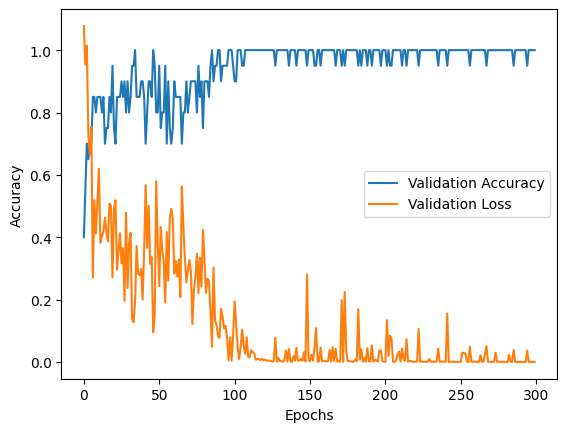

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
test_set_oh = convert_to_one_hot(test_set)
test_set_oh_dir = subset_dir + filename_root + f"tr_ {train_ratio:.2f}" + "_test_set_oh"
os.makedirs(test_set_oh_dir, exist_ok=True)
tf.data.Dataset.save(test_set_oh, test_set_oh_dir)
print(test_set_oh_dir)

../../subsets/gru_sentimento_6m_tr_ 0.80_test_set_oh


In [12]:
import keras
print(model_file)
keras.saving.save_model(model, model_file)

../../sentimento_6m_GRU_modl_sent_encoded_300_mzt_220_B32.keras


In [31]:

test_loss, test_accuracy = model.evaluate(test_set_oh)
print(f"Test accuracy: {test_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step - accuracy: 1.0000 - loss: 0.0278
Test accuracy: 1.0000


In [71]:

predictions = model.predict(test_set_oh)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


In [70]:
# Step 1: Extract true labels and predictions
y_true = []
y_pred = []

for x_batch, y_batch in test_set_oh:
    # Get true labels (one-hot encoded) and convert to class indices
    y_true_batch = tf.argmax(y_batch, axis=1).numpy()  # Convert one-hot to indices
    y_true.extend(y_true_batch)
    
    # Get model predictions and convert to class indices
    y_pred_prob = model.predict(x_batch, verbose=0)  # Predict probabilities
    y_pred_batch = tf.argmax(y_pred_prob, axis=1).numpy()  # Convert to indices
    y_pred.extend(y_pred_batch)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


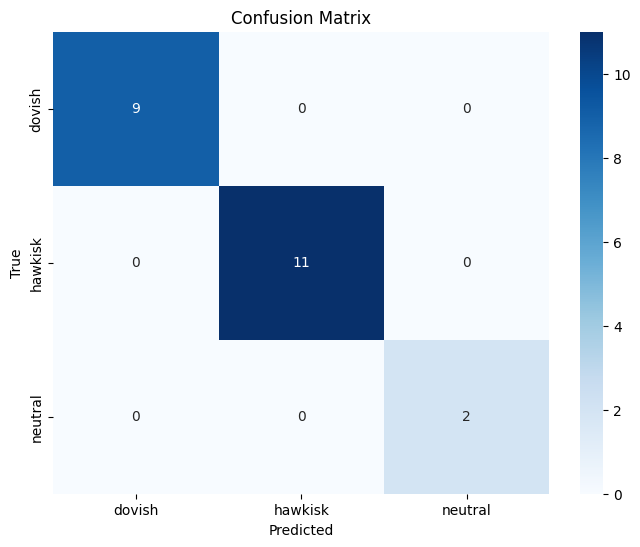

Confusion Matrix:
 [[ 9  0  0]
 [ 0 11  0]
 [ 0  0  2]]


In [69]:
#0 = dovish
#1 = hawkisk
#2 = neutral

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Step 2: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Visualize the confusion matrix (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['dovish', 'hawkisk', 'neutral'], 
            yticklabels=['dovish', 'hawkisk', 'neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

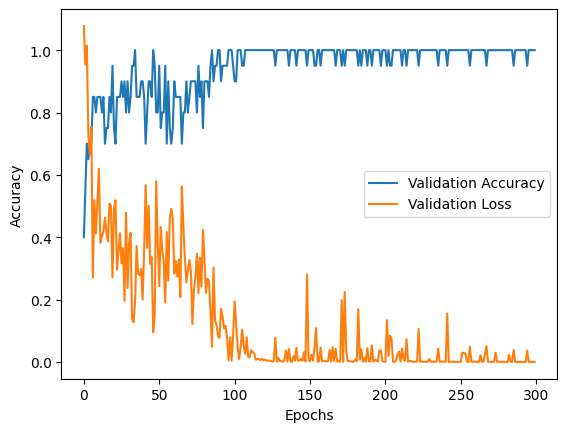

In [72]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()